In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os

# -------------------------------
# 1️⃣ 读取谱线列表文件
# -------------------------------
def read_line_list(filepath):
    lines, freqs = [], []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip() == '':
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            lines.append(parts[0])
            freqs.append(float(parts[1]))
    return lines, np.array(freqs)

# -------------------------------
# 2️⃣ 多文件光谱数据集类
# -------------------------------
class MultiSourceSpectrumDataset(Dataset):
    def __init__(self, data_dir, line_file, window=0.03, target_len=128,
                 normalize=True, velocity_dict=None):
        """
        初始化多源光谱数据集
        
        参数:
        - data_dir: 包含所有光谱文件的目录
        - line_file: 谱线列表文件路径
        - window: 提取窗口大小
        - target_len: 目标子光谱长度
        - normalize: 是否归一化
        - velocity_dict: 字典，键为源名称，值为速度修正值 (km/s)
        """
        self.line_names, self.line_rest = read_line_list(line_file)
        self.c = 299792458  # m/s
        self.window = window
        self.target_len = target_len
        self.normalize = normalize
        
        # 如果没有提供速度字典，创建空字典
        if velocity_dict is None:
            velocity_dict = {}
        
        # 存储所有样本和对应的信息
        self.samples = []        # 光谱数据
        self.full_names = []     # 完整标识符，格式: "源-频率窗口-谱线名称"
        self.source_info = []    # 源信息，格式: (源名称, 频率窗口, 谱线名称)
        self.scales=[]           # 初始化缩放因子列表
        
        # 查找所有光谱文件
        # 假设文件命名格式: "spectrum.源名称.频率窗口.commonbeam.1arcsec.dat"
        pattern = os.path.join(data_dir, "spectrum.*.spw*.commonbeam.1arcsec.dat")
        spectrum_files = glob.glob(pattern)
        
        if not spectrum_files:
            print(f"警告: 在目录 {data_dir} 中没有找到匹配的光谱文件")
            return
        
        print(f"找到 {len(spectrum_files)} 个光谱文件")
        
        # 处理每个光谱文件
        for spectrum_file in spectrum_files:
            # 从文件名中提取源名称和频率窗口
            filename = os.path.basename(spectrum_file)
            parts = filename.split('.')
            if len(parts) < 3:
                print(f"跳过无法解析的文件: {filename}")
                continue
                
            source_name = parts[1]  # 例如 "Lh07"
            spw = parts[2]          # 例如 "spw0"
            
            print(f"处理文件: {filename}, 源: {source_name}, 频率窗口: {spw}")
            
            # 获取该源的速度修正值
            velocity = velocity_dict.get(source_name, None)
            
            # 处理单个光谱文件
            self._process_single_file(spectrum_file, source_name, spw, velocity)
        
        print(f"总共提取了 {len(self.samples)} 个谱线样本")
    
    def _process_single_file(self, spectrum_file, source_name, spw, velocity=None):
        """处理单个光谱文件"""
        try:
            # 读取主光谱，跳过第一行
            data = np.loadtxt(spectrum_file, skiprows=1)
            freq_obs, flux = data[:, 0], data[:, 1]
            
            # 速度校正
            if velocity is not None:
                v = velocity * 1e3  # km/s → m/s
                freq = freq_obs * (1 + v / self.c)
                print(f"  [INFO] 应用速度修正: v = {velocity:.3f} km/s")
            else:
                freq = freq_obs
            
            # 对每条谱线提取子光谱
            for line_name, f_rest in zip(self.line_names, self.line_rest):
                mask = (freq > f_rest - self.window) & (freq < f_rest + self.window)
                if np.sum(mask) < 8:
                    continue  # 跳过数据点太少的谱线
                
                f_sub = freq[mask]
                flux_sub = flux[mask]
                
                # 插值到目标长度
                f_new = np.linspace(f_sub.min(), f_sub.max(), self.target_len)
                flux_new = np.interp(f_new, f_sub, flux_sub)
                
                # 归一化 (可选)
                if self.normalize:
                    #flux_new = (flux_new - np.mean(flux_new)) / (np.std(flux_new) + 1e-6)
                    scale = max(np.max(np.abs(flux_new)), 1e-6)
                    flux_norm = flux_new / scale
                else:
                    scale=1.0
                    flux_norm=flux_new

                
                # 创建完整标识符
                full_name = f"{source_name}-{spw}-{line_name}"
                
                # 保存样本和相关信息
                self.samples.append(torch.tensor(flux_norm, dtype=torch.float32).unsqueeze(0))
                self.full_names.append(full_name)
                self.source_info.append((source_name, spw, line_name))
                self.scales.append(scale)  # 保存了缩放因子

                
        except Exception as e:
            print(f"处理文件 {spectrum_file} 时出错: {e}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.full_names[idx], self.scales[idx]
    
    def get_source_info(self, idx):
        """获取指定索引样本的源信息"""
        return self.source_info[idx]
    
    def get_samples_by_source(self, source_name):
        """获取特定源的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[0] == source_name]
    
    def get_samples_by_spw(self, spw):
        """获取特定频率窗口的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[1] == spw]
    
    def get_samples_by_line(self, line_name):
        """获取特定谱线的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[2] == line_name]

    
def collate_fn(batch):
    """处理批次数据，包括缩放因子"""
    xs = torch.stack([b[0] for b in batch])  # 光谱数据
    names = [b[1] for b in batch]            # 名称列表
    
    scales_list = [b[2] for b in batch]
    scales = torch.tensor(scales_list, dtype=torch.float32)
    scales = scales.view(-1, 1, 1)  # 重塑为 [batch_size, 1, 1]
    
    return xs, names, scales
    
    
# -------------------------------
# 3️⃣ 使用示例
# -------------------------------
if __name__ == "__main__":
    # 数据目录和谱线列表
    data_dir = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\manysource"
    line_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\linelist_lsb.dat"
    
    # 定义各源的速度修正值 (km/s)
    velocity_dict = {
        "Lh07": 239.5157166,
        "Lh09": 235.751358,  
        "Lh10": 251.2273865,  
        # 添加更多源和对应的速度...
    }
    
    # 创建多源数据集
    dataset = MultiSourceSpectrumDataset(
        data_dir=data_dir,
        line_file=line_file,
        velocity_dict=velocity_dict,
        target_len=256,
        normalize=True
    )
    
#     # 打印数据集信息
#     print(f"\n数据集统计:")
#     print(f"总样本数: {len(dataset)}")
    
#     # 按源统计
#     sources = set(info[0] for info in dataset.source_info)
#     for source in sources:
#         count = len(dataset.get_samples_by_source(source))
#         print(f"  {source}: {count} 个样本")
    
#     # 按频率窗口统计
#     spws = set(info[1] for info in dataset.source_info)
#     for spw in spws:
#         count = len(dataset.get_samples_by_spw(spw))
#         print(f"  {spw}: {count} 个样本")
    
#     # 显示前几个样本
#     print(f"\n前5个样本:")
#     for i in range(min(5, len(dataset))):
#         spectrum, full_name, scales = dataset[i]
#         source_info = dataset.get_source_info(i)
#         print(f"  {i+1}. {full_name} (源: {source_info[0]}, 窗口: {source_info[1]}, 谱线: {source_info[2]})")
    
#     # 创建数据加载器
#     dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)  # 怎么把数据集包装成可迭代的批次数据，每个批次包含8各样本（
    
#     # 测试数据加载器
#     for batch_idx, (spectra, names, scales) in enumerate(dataloader):
#         print(f"\n批次 {batch_idx}:")
#         print(f"  光谱形状: {spectra.shape}")
#         print(f"  样本名称: {names[:3]}...")  # 只显示前3个
#         if batch_idx >= 2:  # 只测试前3个批次
#             break

找到 15 个光谱文件
处理文件: spectrum.Lh07.spw0.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw0
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw1.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw1
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw2.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw2
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw3.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw3
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw4.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw4
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh09.spw0.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw0
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw1.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw1
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw2.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw2
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw3.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw3
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw4.commonbeam.1arcsec.dat, 源: Lh09, 频率窗

In [5]:
print(np.shape(dataset[0][0]))

torch.Size([1, 256])


In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ConvolutionalVAE1D(nn.Module):
    def __init__(self, input_length=128, latent_dim=32, base_channels=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.base_channels = base_channels

        self.encoder = nn.Sequential(
            nn.Conv1d(1, base_channels, 4, 2, 1), nn.ReLU(),
            nn.Conv1d(base_channels, base_channels*2, 4, 2, 1), nn.ReLU(),
            nn.Conv1d(base_channels*2, base_channels*4, 4, 2, 1), nn.ReLU(),
        )

        # 256 → 128 → 64 → 32
        self.reduced_len = input_length // 8
        flat_dim = base_channels * 4 * self.reduced_len

        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_z = nn.Linear(latent_dim, flat_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(base_channels*4, base_channels*2, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose1d(base_channels*2, base_channels, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose1d(base_channels, 1, 4, 2, 1) # 删掉激活函数
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        x = self.fc_z(z).view(x.size(0), self.base_channels*4, self.reduced_len)
        x_recon = self.decoder(x)
        
        return x_recon, mu, logvar, z


In [8]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def vae_loss(recon_x, x, mu, logvar, beta=1e-3):
    mse = F.mse_loss(recon_x, x, reduction='mean')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (mse + beta * kld) / x.size(0)

# 初始化模型
model = ConvolutionalVAE1D(input_length=256, latent_dim=32).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for x_batch, name,scales in pbar:  # 注意 dataset 返回 (tensor, name,scales)
        x_batch = x_batch.to(DEVICE)
        scales=scales.to(DEVICE)
        
        optimizer.zero_grad()
        
        recon, mu, logvar, _ = model(x_batch)
        
        loss = vae_loss(recon, x_batch, mu, logvar)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    print(f"Epoch {epoch+1}: avg loss = {total_loss/len(dataloader):.4f}")


Epoch 1/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.07it/s, loss=0.0165]


Epoch 1: avg loss = 0.0157


Epoch 2/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.50it/s, loss=0.0119]


Epoch 2: avg loss = 0.0115


Epoch 3/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.85it/s, loss=0.0106]


Epoch 3: avg loss = 0.0089


Epoch 4/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.39it/s, loss=0.0070]


Epoch 4: avg loss = 0.0066


Epoch 5/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.43it/s, loss=0.0059]


Epoch 5: avg loss = 0.0052


Epoch 6/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.87it/s, loss=0.0050]


Epoch 6: avg loss = 0.0046


Epoch 7/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.27it/s, loss=0.0054]


Epoch 7: avg loss = 0.0044


Epoch 8/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.75it/s, loss=0.0054]


Epoch 8: avg loss = 0.0042


Epoch 9/50: 100%|███████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.47it/s, loss=0.0052]


Epoch 9: avg loss = 0.0041


Epoch 10/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.16it/s, loss=0.0049]


Epoch 10: avg loss = 0.0040


Epoch 11/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.07it/s, loss=0.0048]


Epoch 11: avg loss = 0.0038


Epoch 12/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.94it/s, loss=0.0042]


Epoch 12: avg loss = 0.0037


Epoch 13/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.58it/s, loss=0.0042]


Epoch 13: avg loss = 0.0036


Epoch 14/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.84it/s, loss=0.0049]


Epoch 14: avg loss = 0.0037


Epoch 15/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.32it/s, loss=0.0044]


Epoch 15: avg loss = 0.0037


Epoch 16/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.77it/s, loss=0.0038]


Epoch 16: avg loss = 0.0035


Epoch 17/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.50it/s, loss=0.0040]


Epoch 17: avg loss = 0.0035


Epoch 18/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.36it/s, loss=0.0038]


Epoch 18: avg loss = 0.0034


Epoch 19/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.42it/s, loss=0.0042]


Epoch 19: avg loss = 0.0035


Epoch 20/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.00it/s, loss=0.0047]


Epoch 20: avg loss = 0.0035


Epoch 21/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.45it/s, loss=0.0045]


Epoch 21: avg loss = 0.0034


Epoch 22/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.49it/s, loss=0.0042]


Epoch 22: avg loss = 0.0034


Epoch 23/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.85it/s, loss=0.0045]


Epoch 23: avg loss = 0.0034


Epoch 24/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.69it/s, loss=0.0042]


Epoch 24: avg loss = 0.0034


Epoch 25/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.21it/s, loss=0.0045]


Epoch 25: avg loss = 0.0034


Epoch 26/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.28it/s, loss=0.0038]


Epoch 26: avg loss = 0.0033


Epoch 27/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.25it/s, loss=0.0046]


Epoch 27: avg loss = 0.0035


Epoch 28/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.59it/s, loss=0.0038]


Epoch 28: avg loss = 0.0033


Epoch 29/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.39it/s, loss=0.0039]


Epoch 29: avg loss = 0.0033


Epoch 30/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.39it/s, loss=0.0035]


Epoch 30: avg loss = 0.0033


Epoch 31/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.28it/s, loss=0.0038]


Epoch 31: avg loss = 0.0033


Epoch 32/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.56it/s, loss=0.0041]


Epoch 32: avg loss = 0.0033


Epoch 33/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.91it/s, loss=0.0045]


Epoch 33: avg loss = 0.0033


Epoch 34/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.12it/s, loss=0.0036]


Epoch 34: avg loss = 0.0032


Epoch 35/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.32it/s, loss=0.0047]


Epoch 35: avg loss = 0.0033


Epoch 36/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.14it/s, loss=0.0034]


Epoch 36: avg loss = 0.0032


Epoch 37/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.94it/s, loss=0.0041]


Epoch 37: avg loss = 0.0033


Epoch 38/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.01it/s, loss=0.0038]


Epoch 38: avg loss = 0.0032


Epoch 39/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.59it/s, loss=0.0049]


Epoch 39: avg loss = 0.0034


Epoch 40/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.88it/s, loss=0.0047]


Epoch 40: avg loss = 0.0034


Epoch 41/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.50it/s, loss=0.0038]


Epoch 41: avg loss = 0.0032


Epoch 42/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.23it/s, loss=0.0044]


Epoch 42: avg loss = 0.0034


Epoch 43/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.97it/s, loss=0.0045]


Epoch 43: avg loss = 0.0033


Epoch 44/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.64it/s, loss=0.0037]


Epoch 44: avg loss = 0.0032


Epoch 45/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.57it/s, loss=0.0039]


Epoch 45: avg loss = 0.0033


Epoch 46/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.19it/s, loss=0.0036]


Epoch 46: avg loss = 0.0032


Epoch 47/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.22it/s, loss=0.0039]


Epoch 47: avg loss = 0.0032


Epoch 48/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.55it/s, loss=0.0036]


Epoch 48: avg loss = 0.0032


Epoch 49/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.81it/s, loss=0.0036]


Epoch 49: avg loss = 0.0032


Epoch 50/50: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.14it/s, loss=0.0040]

Epoch 50: avg loss = 0.0033


✅ 共对比 120 条谱线


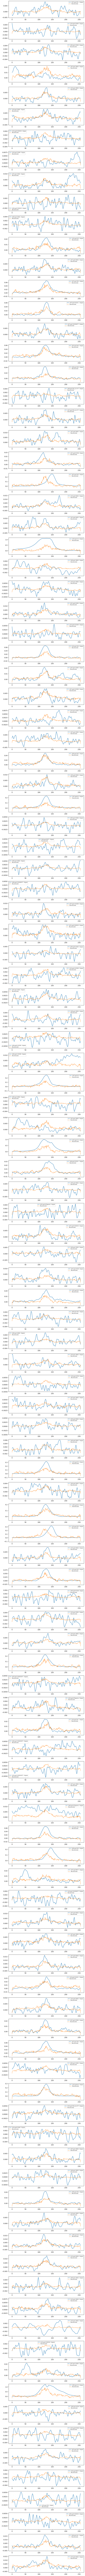

In [9]:
# ============================================
# ✅ 可视化所有样本的原始谱线与重建谱线（修正版）
# ============================================
import matplotlib.pyplot as plt

model.eval()
all_original = []
all_reconstructed = []
all_names = []

with torch.no_grad():
    for x_batch, names, scales_batch in dataloader:

        x_batch = x_batch.to(DEVICE)
        scales_batch = scales_batch.to(DEVICE)

        recon_norm, _, _, _ = model(x_batch)

        # ---- 关键！反归一化恢复原始幅度 ----
        original = x_batch * scales_batch
        recon = recon_norm * scales_batch

        all_original.append(original.cpu())
        all_reconstructed.append(recon.cpu())
        all_names.extend(names)

# 合并成一个大 tensor
all_original = torch.cat(all_original, dim=0).numpy().squeeze(1)
all_reconstructed = torch.cat(all_reconstructed, dim=0).numpy().squeeze(1)

print(f"✅ 共对比 {len(all_names)} 条谱线")

# ==============================
# 绘制所有谱线（每条独立一行）
# ==============================
n = len(all_names)
plt.figure(figsize=(8, 2 * n))

for i in range(n):
    plt.subplot(n, 1, i + 1)
    plt.plot(all_original[i], label=f"{all_names[i]} - Original")
    plt.plot(all_reconstructed[i], label="Reconstructed", linestyle="--")
    plt.legend(fontsize=6)

plt.tight_layout()
plt.show()
